# *Assignment 2: Practical Model Optimization*
## Portfolio 2 : Computer vision
## Group Members: Prahas Hegde, Rohan Sanjay Patil, Vidya Padmanabha


## SETUP and CONFIGURATION

*   Device Setup
*   Hyperparameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.utils.prune as prune
import numpy as np
import time
import copy
import matplotlib.pyplot as plt

# ==========================================
# Configuration - REALISTIC EDGE AI DEPLOYMENT
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
SEED = 42

# Production-grade training for assembly line deployment
EPOCHS_BASELINE = 20      # Proper convergence
EPOCHS_FINETUNE = 3       # Adequate pruning recovery
EPOCHS_ONESHOT = 5        # Better one-shot recovery

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Running on: {DEVICE}")
print(f"Random Seed: {SEED}")
print(f"="*80)
print(f"EDGE AI SCENARIO: Industrial Assembly Line Vehicle Verification")
print(f"="*80)
print(f"Task: Real-time classification of finished cars vs transport trucks")
print(f"Camera: Fixed assembly line position")
print(f"Model: MobileNetV2 (edge-optimized architecture)")
print(f"Transfer Learning: ImageNet pretrained → Fine-tuned on vehicles")
print(f"Target Device: NVIDIA Jetson Nano / Raspberry Pi 4")
print(f"Requirements: >95% accuracy, <10MB size, >10 FPS\n")


Running on: cuda
Random Seed: 42
EDGE AI SCENARIO: Industrial Assembly Line Vehicle Verification
Task: Real-time classification of finished cars vs transport trucks
Camera: Fixed assembly line position
Model: MobileNetV2 (edge-optimized architecture)
Transfer Learning: ImageNet pretrained → Fine-tuned on vehicles
Target Device: NVIDIA Jetson Nano / Raspberry Pi 4
Requirements: >95% accuracy, <10MB size, >10 FPS



#DATA LOADING
* Data augmentation transforms
* Train and test loaders

In [ ]:
# ==========================================
# Data Loading
# ==========================================
def get_data_loaders():
    # Industrial-grade augmentation for real-world conditions
    transform_train = transforms.Compose([
        transforms.Resize(96),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),  # Lighting variations
        transforms.RandomRotation(5),  # Slight angle variations on assembly line
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet stats
    ])

    transform_test = transforms.Compose([
        transforms.Resize(96),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform_train)
    test_set = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform_test)

    def filter_classes(dataset, targets):
        idx = [i for i, label in enumerate(dataset.labels) if label in targets]
        dataset.data = dataset.data[idx]
        dataset.labels = np.array(dataset.labels)[idx]
        dataset.labels = np.where(dataset.labels == targets[0], 0, 1)
        return dataset

    # Class 3 = Car, Class 9 = Truck
    train_set = filter_classes(train_set, [3, 9])
    test_set = filter_classes(test_set, [3, 9])

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"Training samples: {len(train_set)} | Test samples: {len(test_set)}")
    return trainloader, testloader

trainloader, testloader = get_data_loaders()


100%|██████████| 2.64G/2.64G [01:13<00:00, 35.8MB/s]


Training samples: 1000 | Test samples: 1600


# MODEL UTILITIES


In [ ]:
# ==========================================
# Helper Functions
# ==========================================

def train_model(model, loader, epochs, lr_start=1e-3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_start)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"      Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(loader):.4f}")

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def get_stats(model):
    total_params = 0
    nonzero_params = 0
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            w = module.weight
            total_params += w.numel()
            nonzero_params += torch.count_nonzero(w).item()

    if total_params == 0:
        return 0, 0
    sparsity = 100 * (1 - nonzero_params / total_params)
    size_mb = (nonzero_params * 4) / (1024 * 1024)
    return sparsity, size_mb

def measure_time(model):
    model.eval()
    dummy_input = torch.randn(1, 3, 96, 96).to(DEVICE)

    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = model(dummy_input)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    end = time.time()
    return ((end - start) / 100) * 1000


#PRUNING METHODS
* prune_l2_structured(): L2-norm based filter pruning
* prune_taylor_1st_order(): Taylor expansion importance

In [ ]:
# ==========================================
# Pruning Functions
# ==========================================

def prune_l2_global(model, target_sparsity):
    """L2 Energy-based global pruning"""
    # Remove existing pruning
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if prune.is_pruned(module):
                prune.remove(module, 'weight')

    # Collect all weights and compute L2 scores
    all_scores = []
    all_modules = []

    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weight = module.weight.data
            l2_scores = weight ** 2
            all_scores.append(l2_scores.view(-1))
            all_modules.append(module)

    if len(all_scores) == 0:
        return

    # Global threshold
    all_scores_flat = torch.cat(all_scores)
    total_params = all_scores_flat.numel()
    num_to_prune = int(target_sparsity * total_params)

    if num_to_prune > 0 and num_to_prune < total_params:
        threshold = torch.kthvalue(all_scores_flat, num_to_prune).values

        for module in all_modules:
            weight = module.weight.data
            l2_scores = weight ** 2
            mask = (l2_scores >= threshold).float()
            prune.custom_from_mask(module, name='weight', mask=mask)

def prune_taylor_global(model, target_sparsity, loader):
    """Taylor gradient-based pruning"""
    # Remove existing pruning
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if prune.is_pruned(module):
                prune.remove(module, 'weight')

    # Compute gradients
    model.train()
    model.zero_grad()

    iter_loader = iter(loader)
    for _ in range(10):
        try:
            inputs, labels = next(iter_loader)
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
        except StopIteration:
            break

    # Collect importance scores
    all_scores = []
    all_modules = []

    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weight = module.weight.data
            grad = module.weight.grad

            if grad is not None:
                importance = torch.abs(weight * grad)
                all_scores.append(importance.view(-1))
                all_modules.append(module)

    if len(all_scores) == 0:
        return

    # Global threshold
    all_scores_flat = torch.cat(all_scores)
    total_params = all_scores_flat.numel()
    num_to_prune = int(target_sparsity * total_params)

    if num_to_prune > 0 and num_to_prune < total_params:
        threshold = torch.kthvalue(all_scores_flat, num_to_prune).values

        for module in all_modules:
            weight = module.weight.data
            grad = module.weight.grad
            importance = torch.abs(weight * grad)
            mask = (importance >= threshold).float()
            prune.custom_from_mask(module, name='weight', mask=mask)

    model.zero_grad()

def get_fresh_model():
    """Create model WITH pretrained weights for production deployment"""
    model = models.mobilenet_v2(weights='IMAGENET1K_V1')  # Use pretrained!
    model.classifier[1] = nn.Linear(model.last_channel, 2)
    model.to(DEVICE)
    return model

# ==========================================
# Iterative Pruning
# ==========================================

def iterative_prune_to_target(model, target_sparsity, method='l2', loader=None):
    """Iteratively prune to exact target"""
    if target_sparsity == 30:
        intermediate_targets = [10, 20, 30]
    elif target_sparsity == 50:
        intermediate_targets = [15, 30, 50]
    elif target_sparsity == 70:
        intermediate_targets = [20, 40, 70]
    else:
        intermediate_targets = [target_sparsity]

    for i, abs_target in enumerate(intermediate_targets):
        # Remove existing pruning
        for module in model.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                if prune.is_pruned(module):
                    prune.remove(module, 'weight')

        # Apply pruning
        if method == 'l2':
            prune_l2_global(model, abs_target / 100.0)
        else:  # taylor
            prune_taylor_global(model, abs_target / 100.0, loader)

        # Fine-tune
        print(f"      → Step {i+1}: Pruning to {abs_target}% and fine-tuning...")
        train_model(model, trainloader, epochs=EPOCHS_FINETUNE)

        sp, _ = get_stats(model)
        acc = evaluate_model(model, testloader)
        print(f"        Achieved: {sp:.1f}% sparse, {acc:.2f}% accuracy")

#EXPERIMENT EXECUTION
* run_experiment(): Orchestrates pruning + fine-tuning

In [ ]:
# ==========================================
# Main Experiment
# ==========================================

print("\n" + "="*80)
print("ASSEMBLY LINE PRUNING: L2 vs TAYLOR COMPARISON")
print("="*80)

results = []

# BASELINE - Production Model
print("\n[1/13] Training Baseline Production Model...")
print("        (Transfer learning from ImageNet)")
baseline = get_fresh_model()
train_model(baseline, trainloader, epochs=EPOCHS_BASELINE, lr_start=1e-3)

base_sp, base_sz = get_stats(baseline)
base_acc = evaluate_model(baseline, testloader)
base_time = measure_time(baseline)

results.append(['Baseline', base_sp, base_acc, base_sz, base_time])
print(f"\n        ✓ Production Ready: {base_acc:.2f}% accuracy")
print(f"        ✓ Model Size: {base_sz:.2f} MB")
print(f"        ✓ Inference: {base_time:.2f} ms ({1000/base_time:.1f} FPS)")

# Check deployment criteria
if base_acc >= 95.0:
    print(f"        ✓ PASSED: Accuracy meets >95% requirement")
else:
    print(f"        ⚠ WARNING: Accuracy below 95% requirement")

targets = [30, 50, 70]
counter = 2

# L2 ITERATIVE
print("\n" + "="*80)
print("L2 ENERGY-BASED PRUNING (Iterative)")
print("="*80)
for target in targets:
    print(f"\n[{counter}/13] L2 Iterative → {target}% Target:")
    model = copy.deepcopy(baseline)
    iterative_prune_to_target(model, target, method='l2', loader=trainloader)

    sp, sz = get_stats(model)
    acc = evaluate_model(model, testloader)
    t = measure_time(model)

    results.append([f'L2 Iter {target}%', sp, acc, sz, t])
    print(f"        ✓ Final: {sp:.1f}% sparse, {acc:.2f}% accuracy, {sz:.2f} MB")
    counter += 1

# L2 ONE-SHOT
print("\n" + "="*80)
print("L2 ENERGY-BASED PRUNING (One-Shot)")
print("="*80)
for target in targets:
    print(f"\n[{counter}/13] L2 One-Shot → {target}% Target:")
    model = copy.deepcopy(baseline)
    prune_l2_global(model, target / 100.0)
    print(f"        → Fine-tuning pruned model...")
    train_model(model, trainloader, epochs=EPOCHS_ONESHOT)

    sp, sz = get_stats(model)
    acc = evaluate_model(model, testloader)
    t = measure_time(model)

    results.append([f'L2 One-Shot {target}%', sp, acc, sz, t])
    print(f"        ✓ Final: {sp:.1f}% sparse, {acc:.2f}% accuracy, {sz:.2f} MB")
    counter += 1

# TAYLOR ITERATIVE
print("\n" + "="*80)
print("TAYLOR GRADIENT-BASED PRUNING (Iterative)")
print("="*80)
for target in targets:
    print(f"\n[{counter}/13] Taylor Iterative → {target}% Target:")
    model = copy.deepcopy(baseline)
    iterative_prune_to_target(model, target, method='taylor', loader=trainloader)

    sp, sz = get_stats(model)
    acc = evaluate_model(model, testloader)
    t = measure_time(model)

    results.append([f'Taylor Iter {target}%', sp, acc, sz, t])
    print(f"        ✓ Final: {sp:.1f}% sparse, {acc:.2f}% accuracy, {sz:.2f} MB")
    counter += 1

# TAYLOR ONE-SHOT
print("\n" + "="*80)
print("TAYLOR GRADIENT-BASED PRUNING (One-Shot)")
print("="*80)
for target in targets:
    print(f"\n[{counter}/13] Taylor One-Shot → {target}% Target:")
    model = copy.deepcopy(baseline)
    prune_taylor_global(model, target / 100.0, trainloader)
    print(f"        → Fine-tuning pruned model...")
    train_model(model, trainloader, epochs=EPOCHS_ONESHOT)

    sp, sz = get_stats(model)
    acc = evaluate_model(model, testloader)
    t = measure_time(model)

    results.append([f'Taylor One-Shot {target}%', sp, acc, sz, t])
    print(f"        ✓ Final: {sp:.1f}% sparse, {acc:.2f}% accuracy, {sz:.2f} MB")
    counter += 1

# ==========================================
# SUMMARY TABLE
# ==========================================

print("\n\n")
print("="*80)
print("PRUNING EXPERIMENTS SUMMARY - ASSEMBLY LINE DEPLOYMENT")
print("="*80)
print(f"{'Method':<25} {'Sparsity':<12} {'Accuracy':<12} {'Size (MB)':<12} {'Time (ms)':<10}")
print("-" * 80)

for row in results:
    method, sparse, acc, size, t = row
    meets_req = "✓" if acc >= 95.0 and size <= 10.0 else " "
    print(f"{meets_req} {method:<23} {sparse:<11.1f}% {acc:<11.2f}% {size:<11.2f} {t:.2f}")

print("-" * 80)
print("✓ = Meets deployment criteria (>95% accuracy, <10MB size)")


ASSEMBLY LINE PRUNING: L2 vs TAYLOR COMPARISON

[1/13] Training Baseline Production Model...
        (Transfer learning from ImageNet)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


      Epoch 1/20 - Loss: 0.2488
      Epoch 5/20 - Loss: 0.0444
      Epoch 10/20 - Loss: 0.0090
      Epoch 15/20 - Loss: 0.0138
      Epoch 20/20 - Loss: 0.0012

        ✓ Production Ready: 99.06% accuracy
        ✓ Model Size: 8.36 MB
        ✓ Inference: 4.99 ms (200.4 FPS)
        ✓ PASSED: Accuracy meets >95% requirement

L2 ENERGY-BASED PRUNING (Iterative)

[2/13] L2 Iterative → 30% Target:
      → Step 1: Pruning to 10% and fine-tuning...
      Epoch 1/3 - Loss: 0.0640
        Achieved: 10.0% sparse, 99.12% accuracy
      → Step 2: Pruning to 20% and fine-tuning...
      Epoch 1/3 - Loss: 0.0695
        Achieved: 20.0% sparse, 99.12% accuracy
      → Step 3: Pruning to 30% and fine-tuning...
      Epoch 1/3 - Loss: 0.1119
        Achieved: 30.0% sparse, 99.00% accuracy
        ✓ Final: 30.0% sparse, 99.00% accuracy, 5.85 MB

[3/13] L2 Iterative → 50% Target:
      → Step 1: Pruning to 15% and fine-tuning...
      Epoch 1/3 - Loss: 0.0442
        Achieved: 15.0% sparse, 99.38% a

#RESULTS & ANALYSIS




Generating visualizations...
✓ Saved: assembly_line_pruning_results.png

✓ Experiment completed! Check 'assembly_line_pruning_results.png'


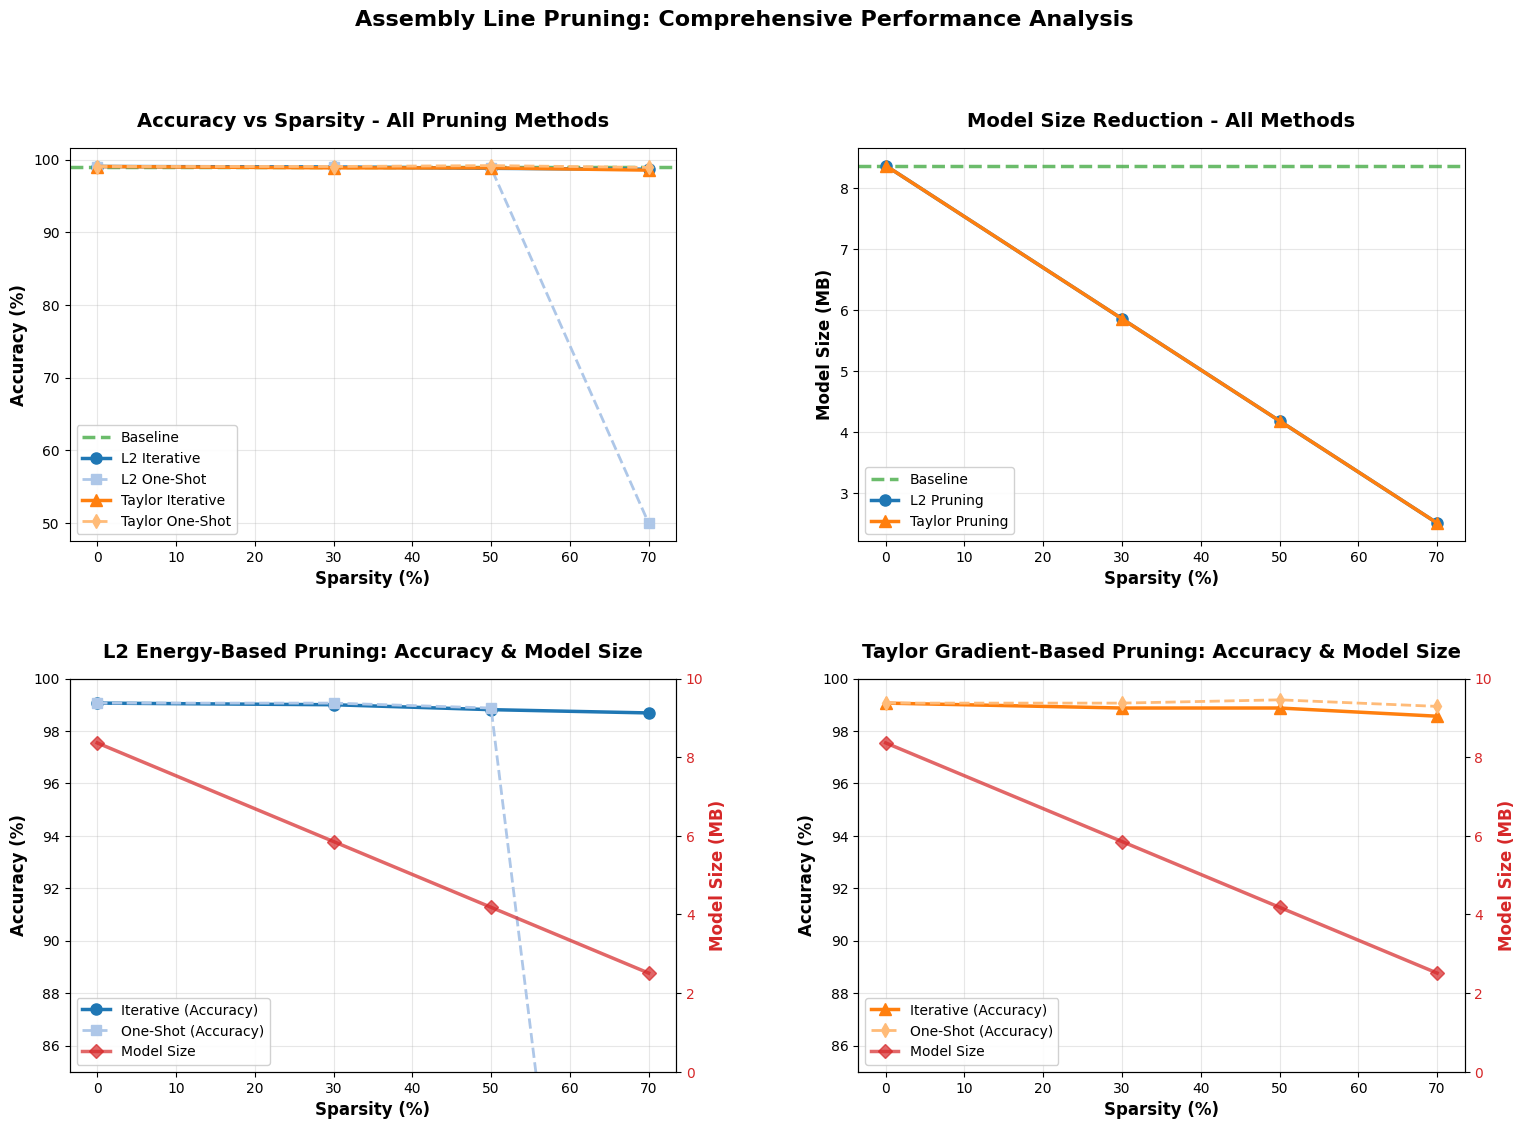

In [ ]:
# ==========================================
# VISUALIZATIONS
# ==========================================

print("\n\nGenerating visualizations...")

baseline_data = results[0]
l2_iter_data = [results[1], results[2], results[3]]
l2_oneshot_data = [results[4], results[5], results[6]]
taylor_iter_data = [results[7], results[8], results[9]]
taylor_oneshot_data = [results[10], results[11], results[12]]

# Create 2x2 grid for line charts
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)

# Color scheme
L2_ITER_COLOR = '#1f77b4'
L2_ONESHOT_COLOR = '#aec7e8'
TAYLOR_ITER_COLOR = '#ff7f0e'
TAYLOR_ONESHOT_COLOR = '#ffbb78'
BASELINE_COLOR = '#2ca02c'

# Extract sparsity targets
sparsity_targets = [r[1] for r in l2_iter_data]
sparsity_with_baseline = [0] + sparsity_targets

# ========== CHART 1: ALL METHODS - ACCURACY VS SPARSITY ==========
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Accuracy vs Sparsity - All Pruning Methods', fontsize=14, fontweight='bold', pad=15)

# Baseline
ax1.axhline(y=baseline_data[2], color=BASELINE_COLOR, linestyle='--', linewidth=2.5,
            label='Baseline', alpha=0.7)

# L2 methods
l2_iter_acc = [baseline_data[2]] + [r[2] for r in l2_iter_data]
l2_oneshot_acc = [baseline_data[2]] + [r[2] for r in l2_oneshot_data]
ax1.plot(sparsity_with_baseline, l2_iter_acc, 'o-', linewidth=2.5, markersize=8,
         label='L2 Iterative', color=L2_ITER_COLOR)
ax1.plot(sparsity_with_baseline, l2_oneshot_acc, 's--', linewidth=2, markersize=7,
         label='L2 One-Shot', color=L2_ONESHOT_COLOR)

# Taylor methods
taylor_iter_acc = [baseline_data[2]] + [r[2] for r in taylor_iter_data]
taylor_oneshot_acc = [baseline_data[2]] + [r[2] for r in taylor_oneshot_data]
ax1.plot(sparsity_with_baseline, taylor_iter_acc, '^-', linewidth=2.5, markersize=8,
         label='Taylor Iterative', color=TAYLOR_ITER_COLOR)
ax1.plot(sparsity_with_baseline, taylor_oneshot_acc, 'd--', linewidth=2, markersize=7,
         label='Taylor One-Shot', color=TAYLOR_ONESHOT_COLOR)

ax1.set_xlabel('Sparsity (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)

# ========== CHART 2: ALL METHODS - MODEL SIZE REDUCTION ==========
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Model Size Reduction - All Methods', fontsize=14, fontweight='bold', pad=15)

# Baseline
ax2.axhline(y=baseline_data[3], color=BASELINE_COLOR, linestyle='--', linewidth=2.5,
            label='Baseline', alpha=0.7)

# All methods (size is same for iterative vs one-shot, just show one of each)
l2_size = [baseline_data[3]] + [r[3] for r in l2_iter_data]
taylor_size = [baseline_data[3]] + [r[3] for r in taylor_iter_data]

ax2.plot(sparsity_with_baseline, l2_size, 'o-', linewidth=2.5, markersize=8,
         label='L2 Pruning', color=L2_ITER_COLOR)
ax2.plot(sparsity_with_baseline, taylor_size, '^-', linewidth=2.5, markersize=8,
         label='Taylor Pruning', color=TAYLOR_ITER_COLOR)

ax2.set_xlabel('Sparsity (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3)

# ========== CHART 3: L2 ONLY - ACCURACY & SIZE ==========
ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title('L2 Energy-Based Pruning: Accuracy & Model Size', fontsize=14, fontweight='bold', pad=15)

# Create twin axis for size
ax3_twin = ax3.twinx()

# Accuracy lines (left axis)
ax3.plot(sparsity_with_baseline, l2_iter_acc, 'o-', linewidth=2.5, markersize=8,
         label='Iterative (Accuracy)', color=L2_ITER_COLOR)
ax3.plot(sparsity_with_baseline, l2_oneshot_acc, 's--', linewidth=2, markersize=7,
         label='One-Shot (Accuracy)', color=L2_ONESHOT_COLOR)

# Size line (right axis)
ax3_twin.plot(sparsity_with_baseline, l2_size, 'D-', linewidth=2.5, markersize=7,
              label='Model Size', color='#d62728', alpha=0.7)

ax3.set_xlabel('Sparsity (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold', color='black')
ax3_twin.set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold', color='#d62728')
ax3_twin.tick_params(axis='y', labelcolor='#d62728')

# Set consistent y-axis ranges
ax3.set_ylim([85, 100])  # Same accuracy range for both charts
ax3_twin.set_ylim([0, 10])  # Same size range for both charts

# Combine legends
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10, framealpha=0.9)

ax3.grid(True, alpha=0.3)

# ========== CHART 4: TAYLOR ONLY - ACCURACY & SIZE ==========
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title('Taylor Gradient-Based Pruning: Accuracy & Model Size', fontsize=14, fontweight='bold', pad=15)

# Create twin axis for size
ax4_twin = ax4.twinx()

# Accuracy lines (left axis)
ax4.plot(sparsity_with_baseline, taylor_iter_acc, '^-', linewidth=2.5, markersize=8,
         label='Iterative (Accuracy)', color=TAYLOR_ITER_COLOR)
ax4.plot(sparsity_with_baseline, taylor_oneshot_acc, 'd--', linewidth=2, markersize=7,
         label='One-Shot (Accuracy)', color=TAYLOR_ONESHOT_COLOR)

# Size line (right axis)
ax4_twin.plot(sparsity_with_baseline, taylor_size, 'D-', linewidth=2.5, markersize=7,
              label='Model Size', color='#d62728', alpha=0.7)

ax4.set_xlabel('Sparsity (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold', color='black')
ax4_twin.set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold', color='#d62728')
ax4_twin.tick_params(axis='y', labelcolor='#d62728')

# Set consistent y-axis ranges
ax4.set_ylim([85, 100])  # Same accuracy range for both charts
ax4_twin.set_ylim([0, 10])  # Same size range for both charts

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10, framealpha=0.9)

ax4.grid(True, alpha=0.3)

# Overall title
fig.suptitle('Assembly Line Pruning: Comprehensive Performance Analysis',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('assembly_line_pruning_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: assembly_line_pruning_results.png")

print("\n" + "="*90)
print("✓ Experiment completed! Check 'assembly_line_pruning_results.png'")
print("="*90)

plt.show()